# Feature Family 1: Momentum & Smoothing

---

## Research Hypothesis

> **"Short-horizon daily returns are dominated by noise, but aggregating returns across multiple short-to-medium horizons recovers weak cross-sectional structure due to gradual information diffusion."**

### Constraints Checklist

| Constraint | Status |
|------------|--------|
| Baseline model unchanged | ✅ Using frozen `Pipeline` |
| No hyperparameter tuning | ✅ |
| No regime/volume/cross-asset | ✅ |
| Same hypothesis for all features | ✅ |

---

## 1. Setup & Pipeline Import

In [1]:
import sys
sys.path.append('..')

# Force reload the module
import importlib
import src.pipeline
importlib.reload(src.pipeline)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import torch

# Import our frozen pipeline (reloaded)
from src.pipeline import Pipeline, DEFAULT_PARAMS, standardize_features

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

print("Pipeline imported successfully!")
print(f"Frozen parameters: {DEFAULT_PARAMS}")

Pipeline imported successfully!
Frozen parameters: {'ridge_alpha': 1.0, 'training_window': 252, 'long_pct': 0.2, 'short_pct': 0.2, 'transaction_cost_bps': 10, 'trading_days_per_year': 252}


In [3]:
import torch
torch.cuda.is_available()
print(torch.cuda.get_device_name(0))


NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
# Initialize pipeline and load data
pipeline = Pipeline()
pipeline.load_data('../data/processed/df_after_eda.parquet')

# Quick access to panel data
panel = pipeline.panel
returns = panel['returns']

Data loaded: 2511 days x 100 assets


---

## 2. Feature Engineering: Momentum Block

| Feature | Formula | Horizon |
|---------|---------|----------|
| `mom_3d` | Σr(t-k) / σ₂₀ | 3 days |
| `mom_5d` | Σr(t-k) / σ₂₀ | 5 days |
| `mom_10d` | Σr(t-k) / σ₂₀ | 10 days |

In [5]:
def compute_momentum_features(returns: pd.DataFrame) -> dict:
    """
    Momentum Block: cumulative returns at different horizons, volatility-normalized.
    """
    vol_20d = returns.rolling(window=20, min_periods=15).std()
    
    features = {
        'mom_3d': returns.rolling(3).sum() / vol_20d,
        'mom_5d': returns.rolling(5).sum() / vol_20d,
        'mom_10d': returns.rolling(10).sum() / vol_20d,
    }
    
    return features

# Compute features
features_momentum = compute_momentum_features(returns)

print("Momentum Block Features:")
for name, feat in features_momentum.items():
    valid = feat.notna().sum().sum()
    print(f"  {name}: {valid:,} valid observations")

Momentum Block Features:
  mom_3d: 249,600 valid observations
  mom_5d: 249,600 valid observations
  mom_10d: 249,600 valid observations


---

## 3. Run Pipeline & Compare to Baseline

In [6]:
# Run momentum model WITH BASELINE (combined features)
print("Running Baseline + Momentum Block model...")
results_momentum = pipeline.run_with_baseline(features_momentum, verbose=True)

Running Baseline + Momentum Block model...
Running with baseline (3 features) + new (3 features) = 6 total
Pre-aligning data...
Running rolling regression from index 302 to 2511...
  Training window: 252 days
  Ridge alpha: 1.0
  Features (6): ['f1_short_mom_norm', 'f2_medium_mom', 'f3_volatility', 'mom_3d', 'mom_5d', 'mom_10d']
  Processing day 400/2511 (2017-08-24)...
  Processing day 500/2511 (2018-01-18)...
  Processing day 600/2511 (2018-06-12)...
  Processing day 700/2511 (2018-11-01)...
  Processing day 800/2511 (2019-03-29)...
  Processing day 900/2511 (2019-08-21)...
  Processing day 1000/2511 (2020-01-14)...
  Processing day 1100/2511 (2020-06-08)...
  Processing day 1200/2511 (2020-10-28)...
  Processing day 1300/2511 (2021-03-24)...
  Processing day 1400/2511 (2021-08-16)...
  Processing day 1500/2511 (2022-01-06)...
  Processing day 1600/2511 (2022-06-01)...
  Processing day 1700/2511 (2022-10-24)...
  Processing day 1800/2511 (2023-03-20)...
  Processing day 1900/2511 (20

In [7]:
# Run baseline for comparison (cached after first run)
print("Running Baseline model...")
results_baseline = pipeline.run_baseline(verbose=True)

Running Baseline model...
Running baseline model...
Pre-aligning data...
Running rolling regression from index 302 to 2511...
  Training window: 252 days
  Ridge alpha: 1.0
  Features (3): ['f1_short_mom_norm', 'f2_medium_mom', 'f3_volatility']
  Processing day 400/2511 (2017-08-24)...
  Processing day 500/2511 (2018-01-18)...
  Processing day 600/2511 (2018-06-12)...
  Processing day 700/2511 (2018-11-01)...
  Processing day 800/2511 (2019-03-29)...
  Processing day 900/2511 (2019-08-21)...
  Processing day 1000/2511 (2020-01-14)...
  Processing day 1100/2511 (2020-06-08)...
  Processing day 1200/2511 (2020-10-28)...
  Processing day 1300/2511 (2021-03-24)...
  Processing day 1400/2511 (2021-08-16)...
  Processing day 1500/2511 (2022-01-06)...
  Processing day 1600/2511 (2022-06-01)...
  Processing day 1700/2511 (2022-10-24)...
  Processing day 1800/2511 (2023-03-20)...
  Processing day 1900/2511 (2023-08-11)...
  Processing day 2000/2511 (2024-01-04)...
  Processing day 2100/2511 (20

In [8]:
# Print comparison to baseline
pipeline.print_comparison(results_momentum, results_baseline)

# Update best model tracker
pipeline.update_best_model(results_momentum, "baseline_plus_momentum_v1")
pipeline.print_leaderboard()


PERFORMANCE COMPARISON vs BASELINE
             Metric  Baseline  New Model   Delta
       Gross Sharpe    0.0292     0.0384  0.0092
         Net Sharpe   -0.5884    -0.8844 -0.2960
Annual Return (Net)  -10.6411   -15.0630 -4.4219
 Max Drawdown (Net)  -75.4019   -83.3644 -7.9626
    Annual Turnover  111.6766   157.1606 45.4840
    Long Leg Sharpe    0.8716     0.9048  0.0333
   Short Leg Sharpe   -0.9801    -0.9831 -0.0030

----------------------------------------------------------------------
✅ New model IMPROVES Gross Sharpe by +0.0092

MODEL LEADERBOARD
Rank  Model                    Gross Sharpe   Net Sharpe     Turnover    
--------------------------------------------------------------------------------
👑     baseline_plus_momentum_v10.0384         -0.8844        157.2       
2     baseline_plus_momentum_v10.0384         -0.8844        157.2       
3     baseline_mom_vol_v1      -0.0384        -0.8996        145.5       
-----------------------------------------------------------

---

## 4. Required Diagnostics

### 4.1 Feature Redundancy Analysis

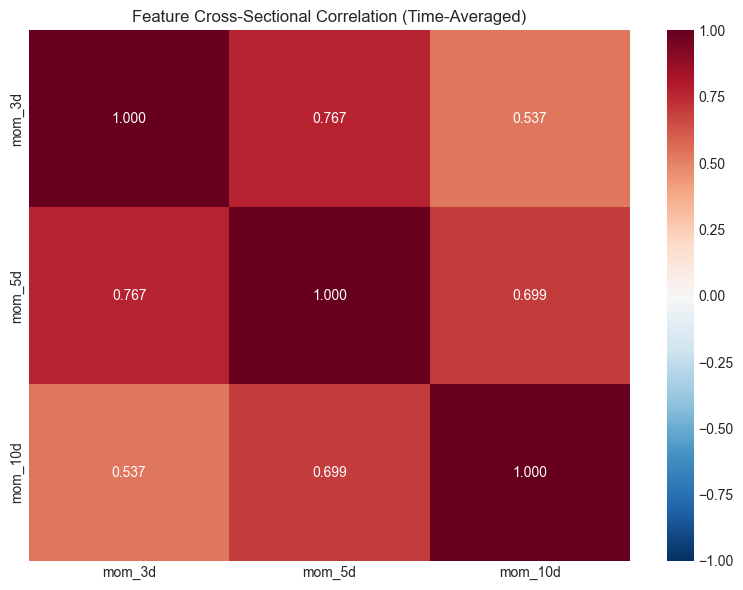


Average pairwise correlation: 0.668
✅ Features have distinct information


In [9]:
def compute_feature_correlations(features: dict) -> pd.DataFrame:
    """Compute time-averaged cross-sectional correlations between features."""
    feature_names = list(features.keys())
    common_dates = features[feature_names[0]].dropna(how='all').index
    
    daily_corrs = []
    for date in common_dates:
        feat_df = pd.DataFrame({fn: features[fn].loc[date] for fn in feature_names}).dropna()
        if len(feat_df) > 10:
            daily_corrs.append(feat_df.corr().values)
    
    mean_corr = np.mean(daily_corrs, axis=0)
    return pd.DataFrame(mean_corr, index=feature_names, columns=feature_names)

corr_matrix = compute_feature_correlations(features_momentum)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title('Feature Cross-Sectional Correlation (Time-Averaged)')
plt.tight_layout()
plt.savefig('../outputs/figures/momentum/01_feature_correlations.png', dpi=150)
plt.show()

# Interpretation
off_diag = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
print(f"\nAverage pairwise correlation: {np.mean(off_diag):.3f}")
if np.mean(off_diag) > 0.7:
    print("⚠️  HIGH REDUNDANCY: Features highly correlated")
else:
    print("✅ Features have distinct information")

### 4.2 Coefficient Stability

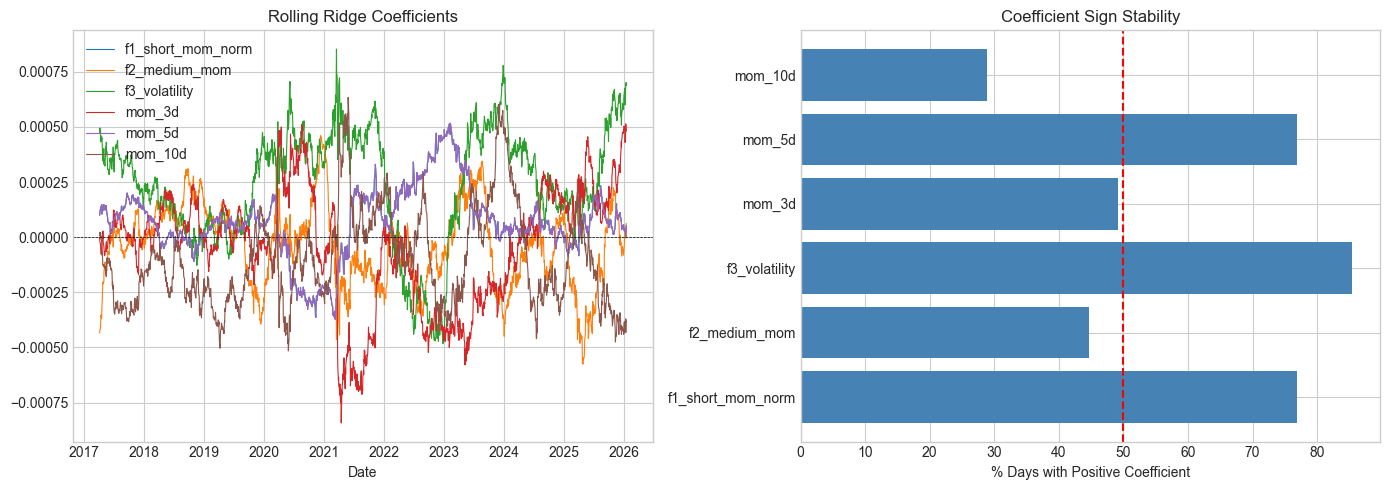


Sign Stability:
  f1_short_mom_norm: 76.9% positive - STABLE
  f2_medium_mom: 44.6% positive - UNSTABLE ⚠️
  f3_volatility: 85.5% positive - STABLE
  mom_3d: 49.2% positive - UNSTABLE ⚠️
  mom_5d: 76.9% positive - STABLE
  mom_10d: 28.8% positive - STABLE


In [10]:
coefficients = results_momentum['coefficients']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rolling coefficients
ax = axes[0]
for col in coefficients.columns:
    if col != 'intercept':
        ax.plot(coefficients.index, coefficients[col], label=col, linewidth=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Rolling Ridge Coefficients')
ax.set_xlabel('Date')
ax.legend()

# Sign stability
ax = axes[1]
sign_stability = {}
for col in coefficients.columns:
    if col != 'intercept':
        coefs = coefficients[col].dropna()
        sign_stability[col] = (coefs > 0).mean() * 100

ax.barh(list(sign_stability.keys()), list(sign_stability.values()), color='steelblue')
ax.axvline(50, color='red', linestyle='--')
ax.set_xlabel('% Days with Positive Coefficient')
ax.set_title('Coefficient Sign Stability')

plt.tight_layout()
plt.savefig('../outputs/figures/momentum/02_coefficient_stability.png', dpi=150)
plt.show()

print("\nSign Stability:")
for col, pct in sign_stability.items():
    status = "STABLE" if pct > 70 or pct < 30 else "UNSTABLE ⚠️"
    print(f"  {col}: {pct:.1f}% positive - {status}")

### 4.3 Contribution Analysis: Cumulative PnL

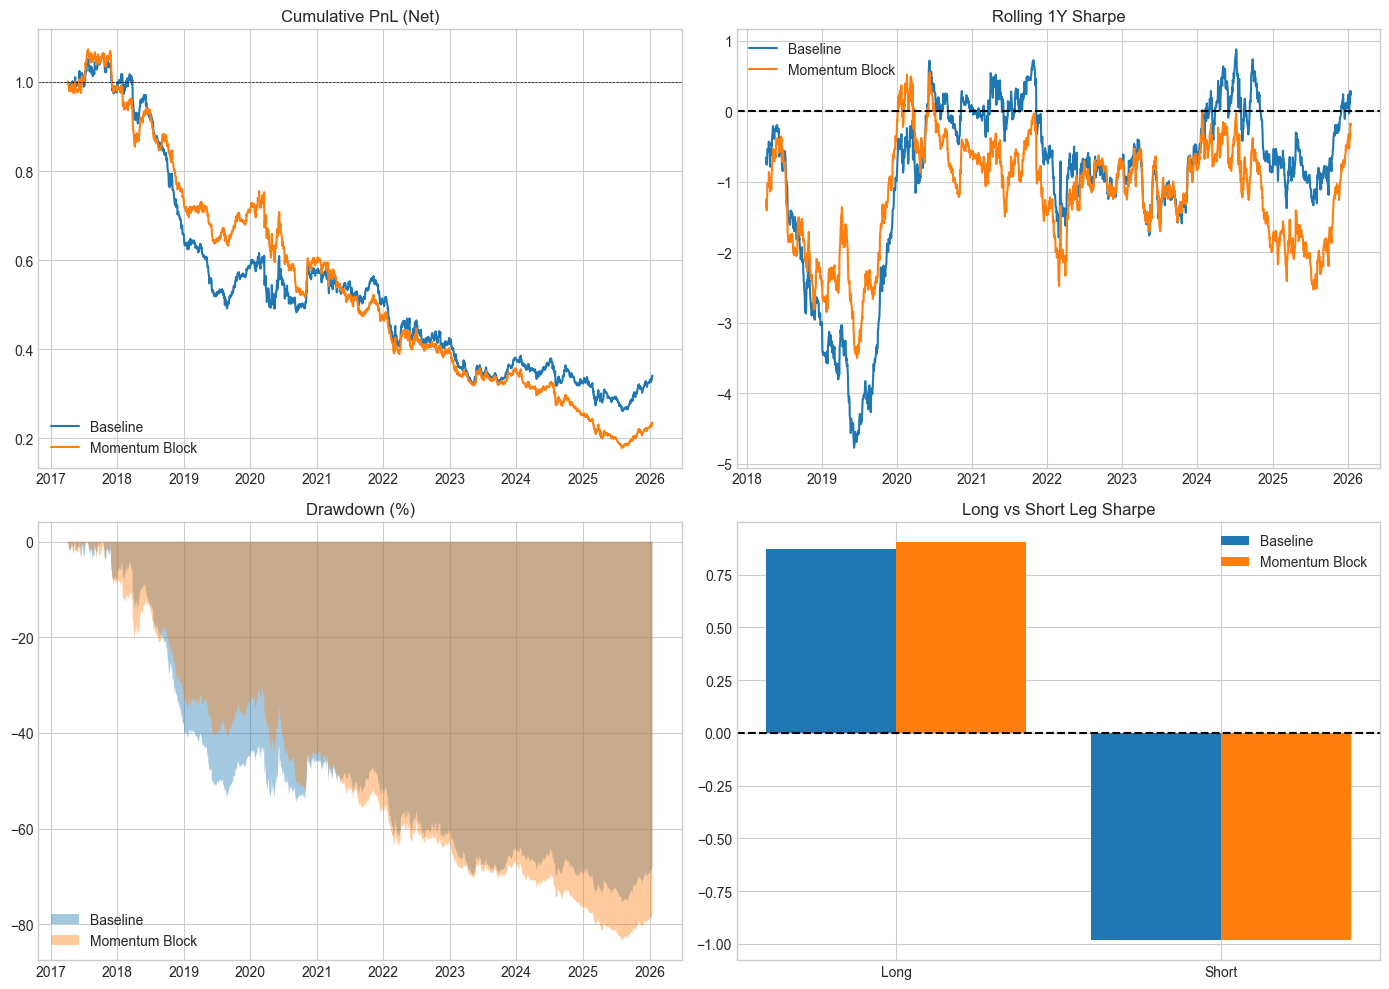

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative PnL
ax = axes[0, 0]
base_cum = (1 + results_baseline['backtest']['net_returns']).cumprod()
mom_cum = (1 + results_momentum['backtest']['net_returns']).cumprod()
common = base_cum.index.intersection(mom_cum.index)
ax.plot(common, base_cum.loc[common], label='Baseline')
ax.plot(common, mom_cum.loc[common], label='Momentum Block')
ax.set_title('Cumulative PnL (Net)')
ax.legend()
ax.axhline(1, color='black', linestyle='--', linewidth=0.5)

# 2. Rolling Sharpe
ax = axes[0, 1]
window = 252
base_sharpe = (results_baseline['backtest']['net_returns'].rolling(window).mean() / 
               results_baseline['backtest']['net_returns'].rolling(window).std() * np.sqrt(252))
mom_sharpe = (results_momentum['backtest']['net_returns'].rolling(window).mean() / 
              results_momentum['backtest']['net_returns'].rolling(window).std() * np.sqrt(252))
ax.plot(base_sharpe.index, base_sharpe, label='Baseline')
ax.plot(mom_sharpe.index, mom_sharpe, label='Momentum Block')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Rolling 1Y Sharpe')
ax.legend()

# 3. Drawdown
ax = axes[1, 0]
base_dd = (base_cum / base_cum.cummax() - 1) * 100
mom_dd = (mom_cum / mom_cum.cummax() - 1) * 100
ax.fill_between(base_dd.index, base_dd, 0, alpha=0.4, label='Baseline')
ax.fill_between(mom_dd.index, mom_dd, 0, alpha=0.4, label='Momentum Block')
ax.set_title('Drawdown (%)')
ax.legend()

# 4. Long vs Short legs
ax = axes[1, 1]
labels = ['Long', 'Short']
base_vals = [results_baseline['metrics']['long']['sharpe'], results_baseline['metrics']['short']['sharpe']]
mom_vals = [results_momentum['metrics']['long']['sharpe'], results_momentum['metrics']['short']['sharpe']]
x = np.arange(2)
ax.bar(x - 0.2, base_vals, 0.4, label='Baseline')
ax.bar(x + 0.2, mom_vals, 0.4, label='Momentum Block')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Long vs Short Leg Sharpe')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/momentum/03_performance_comparison.png', dpi=150)
plt.show()

---

## 5. Regime Analysis

In [12]:
# Market volatility regimes
market_ret = returns.mean(axis=1)
market_vol = market_ret.rolling(60).std() * np.sqrt(252)

common_idx = results_momentum['backtest']['net_returns'].index.intersection(market_vol.dropna().index)
vol_aligned = market_vol.loc[common_idx]
ret_mom = results_momentum['backtest']['net_returns'].loc[common_idx]
ret_base = results_baseline['backtest']['net_returns'].loc[common_idx]

high_vol = vol_aligned > vol_aligned.median()
up_market = market_ret.loc[common_idx] > 0

print("Performance by Regime:")
print("=" * 60)
print(f"{'Regime':<20} {'Baseline':>12} {'Momentum':>12} {'Delta':>10}")
print("-" * 60)

for name, mask in [('High Vol', high_vol), ('Low Vol', ~high_vol), 
                   ('Up Market', up_market), ('Down Market', ~up_market)]:
    b_sharpe = ret_base[mask].mean() / ret_base[mask].std() * np.sqrt(252) if ret_base[mask].std() > 0 else 0
    m_sharpe = ret_mom[mask].mean() / ret_mom[mask].std() * np.sqrt(252) if ret_mom[mask].std() > 0 else 0
    print(f"{name:<20} {b_sharpe:>12.2f} {m_sharpe:>12.2f} {m_sharpe-b_sharpe:>+10.2f}")

Performance by Regime:
Regime                   Baseline     Momentum      Delta
------------------------------------------------------------
High Vol                    -0.69        -0.99      -0.30
Low Vol                     -0.46        -0.77      -0.30
Up Market                    1.82         1.50      -0.32
Down Market                 -3.60        -3.77      -0.17


---

## 6. Final Interpretation

In [13]:
# Extract key metrics for interpretation
base_m = results_baseline['metrics']
mom_m = results_momentum['metrics']

sharpe_delta = mom_m['gross']['sharpe'] - base_m['gross']['sharpe']
turnover_delta = mom_m['gross']['ann_turnover'] - base_m['gross']['ann_turnover']

print("\n" + "=" * 70)
print("FINAL INTERPRETATION")
print("=" * 70)

print(f"\nQ1: Does Momentum Block improve risk-adjusted performance?")
print(f"    Gross Sharpe: {base_m['gross']['sharpe']:.4f} → {mom_m['gross']['sharpe']:.4f} (Δ = {sharpe_delta:+.4f})")
print(f"    ANSWER: {'YES ✅' if sharpe_delta > 0 else 'NO ❌'}")

print(f"\nQ2: Are features redundant or complementary?")
avg_corr = np.mean(off_diag)
print(f"    Avg correlation: {avg_corr:.3f}")
print(f"    ANSWER: {'HIGH REDUNDANCY ⚠️' if avg_corr > 0.7 else 'MODERATE OVERLAP' if avg_corr > 0.4 else 'COMPLEMENTARY ✅'}")

print(f"\nQ3: Does block increase turnover materially?")
print(f"    Turnover: {base_m['gross']['ann_turnover']:.1f}x → {mom_m['gross']['ann_turnover']:.1f}x (Δ = {turnover_delta:+.1f}x)")
print(f"    ANSWER: {'YES ⚠️' if abs(turnover_delta) > 10 else 'NO ✅'}")


FINAL INTERPRETATION

Q1: Does Momentum Block improve risk-adjusted performance?
    Gross Sharpe: 0.0292 → 0.0384 (Δ = +0.0092)
    ANSWER: YES ✅

Q2: Are features redundant or complementary?
    Avg correlation: 0.668
    ANSWER: MODERATE OVERLAP

Q3: Does block increase turnover materially?
    Turnover: 111.7x → 157.2x (Δ = +45.5x)
    ANSWER: YES ⚠️


In [14]:
# Save experiment log
import json
from datetime import datetime

experiment_log = {
    'experiment': 'Feature Family 1: Momentum Block',
    'timestamp': datetime.now().isoformat(),
    'hypothesis': 'Information diffusion across multiple horizons',
    'features': list(features_momentum.keys()),
    'results': {
        'baseline_sharpe': float(base_m['gross']['sharpe']),
        'momentum_sharpe': float(mom_m['gross']['sharpe']),
        'delta': float(sharpe_delta),
    }
}

with open('../outputs/momentum_experiment_log.json', 'w') as f:
    json.dump(experiment_log, f, indent=2)

print("\nExperiment logged to ../outputs/momentum_experiment_log.json")


Experiment logged to ../outputs/momentum_experiment_log.json


---

## Summary

This notebook tested the Momentum Block using the **frozen pipeline** from `src/pipeline.py`. 

Key benefits of this approach:
- No redundant code
- Baseline comparison built-in
- Fast iteration on new feature ideas
- Guaranteed consistency across experiments

---

## Feature Family 2: Volatility Block (State Variables)

These are **conditioning variables**, not direct signals. They tell the model about the current risk environment.

| Feature | Formula | Information Captured |
|---------|---------|---------------------|
| `vol_20d` | σ₂₀ | "How risky is this asset right now?" (LEVEL) |
| `vol_ratio` | σ₂₀ / σ₆₀ | "Is risk increasing or decreasing?" (TREND) |
| `vol_of_vol` | std(σ₂₀) | "Can I trust my risk estimate?" (STABILITY) |

In [15]:
def compute_volatility_block(returns: pd.DataFrame) -> dict:
    """
    Volatility Block: State variables capturing volatility dynamics.
    
    Features:
    1. vol_20d: 20-day realized volatility (LEVEL)
       - Encodes current risk level
       - Required for normalization
       - Cross-sectionally comparable
       
    2. vol_ratio: σ20/σ60 (TREND / REGIME SHIFT)
       - Scale-free
       - Captures volatility expansion vs contraction
       - Detects regime transitions early
       
    3. vol_of_vol: Rolling std of 20d vol (STABILITY / UNCERTAINTY)
       - Detects unstable regimes
       - Identifies "risk of risk"
       - Essential for gating and ensembles
    """
    # 1. Volatility Level (20-day realized vol)
    vol_20d = returns.rolling(window=20, min_periods=15).std()
    
    # 2. Volatility Ratio (trend/regime shift)
    vol_60d = returns.rolling(window=60, min_periods=45).std()
    vol_ratio = vol_20d / vol_60d
    
    # 3. Volatility of Volatility (stability/uncertainty)
    vol_of_vol = vol_20d.rolling(window=20, min_periods=15).std()
    
    return {
        'vol_20d': vol_20d,
        'vol_ratio': vol_ratio,
        'vol_of_vol': vol_of_vol,
    }

# Compute volatility features
features_volatility = compute_volatility_block(returns)

print("Volatility Block Features:")
for name, feat in features_volatility.items():
    valid = feat.notna().sum().sum()
    print(f"  {name}: {valid:,} valid observations")

Volatility Block Features:
  vol_20d: 249,600 valid observations
  vol_ratio: 246,600 valid observations
  vol_of_vol: 248,200 valid observations


In [16]:
# Combine ALL feature blocks: Baseline + Momentum + Volatility
features_all = {**features_momentum, **features_volatility}

print(f"Combined features: {len(features_all)}")
print(f"Feature names: {list(features_all.keys())}")

Combined features: 6
Feature names: ['mom_3d', 'mom_5d', 'mom_10d', 'vol_20d', 'vol_ratio', 'vol_of_vol']


In [17]:
# Run Baseline + Momentum + Volatility model
print("Running Baseline + Momentum + Volatility model...")
results_all = pipeline.run_with_baseline(features_all, verbose=True)

Running Baseline + Momentum + Volatility model...
Running with baseline (3 features) + new (6 features) = 9 total
Pre-aligning data...
Running rolling regression from index 302 to 2511...
  Training window: 252 days
  Ridge alpha: 1.0
  Features (9): ['f1_short_mom_norm', 'f2_medium_mom', 'f3_volatility', 'mom_3d', 'mom_5d', 'mom_10d', 'vol_20d', 'vol_ratio', 'vol_of_vol']
  Processing day 400/2511 (2017-08-24)...
  Processing day 500/2511 (2018-01-18)...
  Processing day 600/2511 (2018-06-12)...
  Processing day 700/2511 (2018-11-01)...
  Processing day 800/2511 (2019-03-29)...
  Processing day 900/2511 (2019-08-21)...
  Processing day 1000/2511 (2020-01-14)...
  Processing day 1100/2511 (2020-06-08)...
  Processing day 1200/2511 (2020-10-28)...
  Processing day 1300/2511 (2021-03-24)...
  Processing day 1400/2511 (2021-08-16)...
  Processing day 1500/2511 (2022-01-06)...
  Processing day 1600/2511 (2022-06-01)...
  Processing day 1700/2511 (2022-10-24)...
  Processing day 1800/2511 (

In [18]:
# Compare to baseline and update leaderboard
pipeline.print_comparison(results_all, results_baseline)

# Update best model tracker
pipeline.update_best_model(results_all, "baseline_mom_vol_v1")
pipeline.print_leaderboard()


PERFORMANCE COMPARISON vs BASELINE
             Metric  Baseline  New Model   Delta
       Gross Sharpe    0.0292    -0.0384 -0.0676
         Net Sharpe   -0.5884    -0.8996 -0.3112
Annual Return (Net)  -10.6411   -15.2036 -4.5626
 Max Drawdown (Net)  -75.4019   -82.8336 -7.4317
    Annual Turnover  111.6766   145.5498 33.8732
    Long Leg Sharpe    0.8716     0.8579 -0.0137
   Short Leg Sharpe   -0.9801    -1.0196 -0.0395

----------------------------------------------------------------------
❌ New model DEGRADES Gross Sharpe by -0.0676

MODEL LEADERBOARD
Rank  Model                    Gross Sharpe   Net Sharpe     Turnover    
--------------------------------------------------------------------------------
👑     baseline_plus_momentum_v10.0384         -0.8844        157.2       
2     baseline_plus_momentum_v10.0384         -0.8844        157.2       
3     baseline_mom_vol_v1      -0.0384        -0.8996        145.5       
4     baseline_mom_vol_v1      -0.0384        -0.8996      

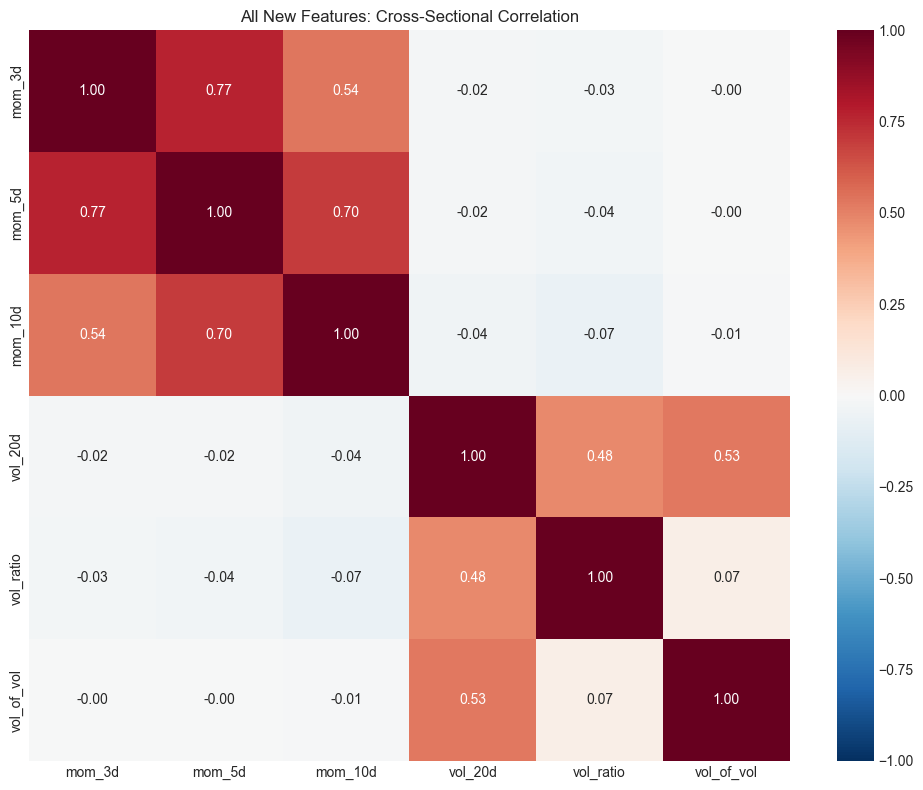


Average pairwise correlation: 0.190
Max correlation: 0.768
✅ Features have distinct information


In [19]:
# Feature correlation analysis (all 6 new features)
all_new_features = {**features_momentum, **features_volatility}
corr_all = compute_feature_correlations(all_new_features)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_all, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title('All New Features: Cross-Sectional Correlation')
plt.tight_layout()
plt.savefig('../outputs/figures/momentum/04_all_features_correlation.png', dpi=150)
plt.show()

# Check redundancy
off_diag_all = corr_all.values[np.triu_indices_from(corr_all.values, k=1)]
print(f"\nAverage pairwise correlation: {np.mean(off_diag_all):.3f}")
print(f"Max correlation: {np.max(off_diag_all):.3f}")
if np.mean(off_diag_all) > 0.5:
    print("⚠️  MODERATE REDUNDANCY: Consider feature selection")
else:
    print("✅ Features have distinct information")

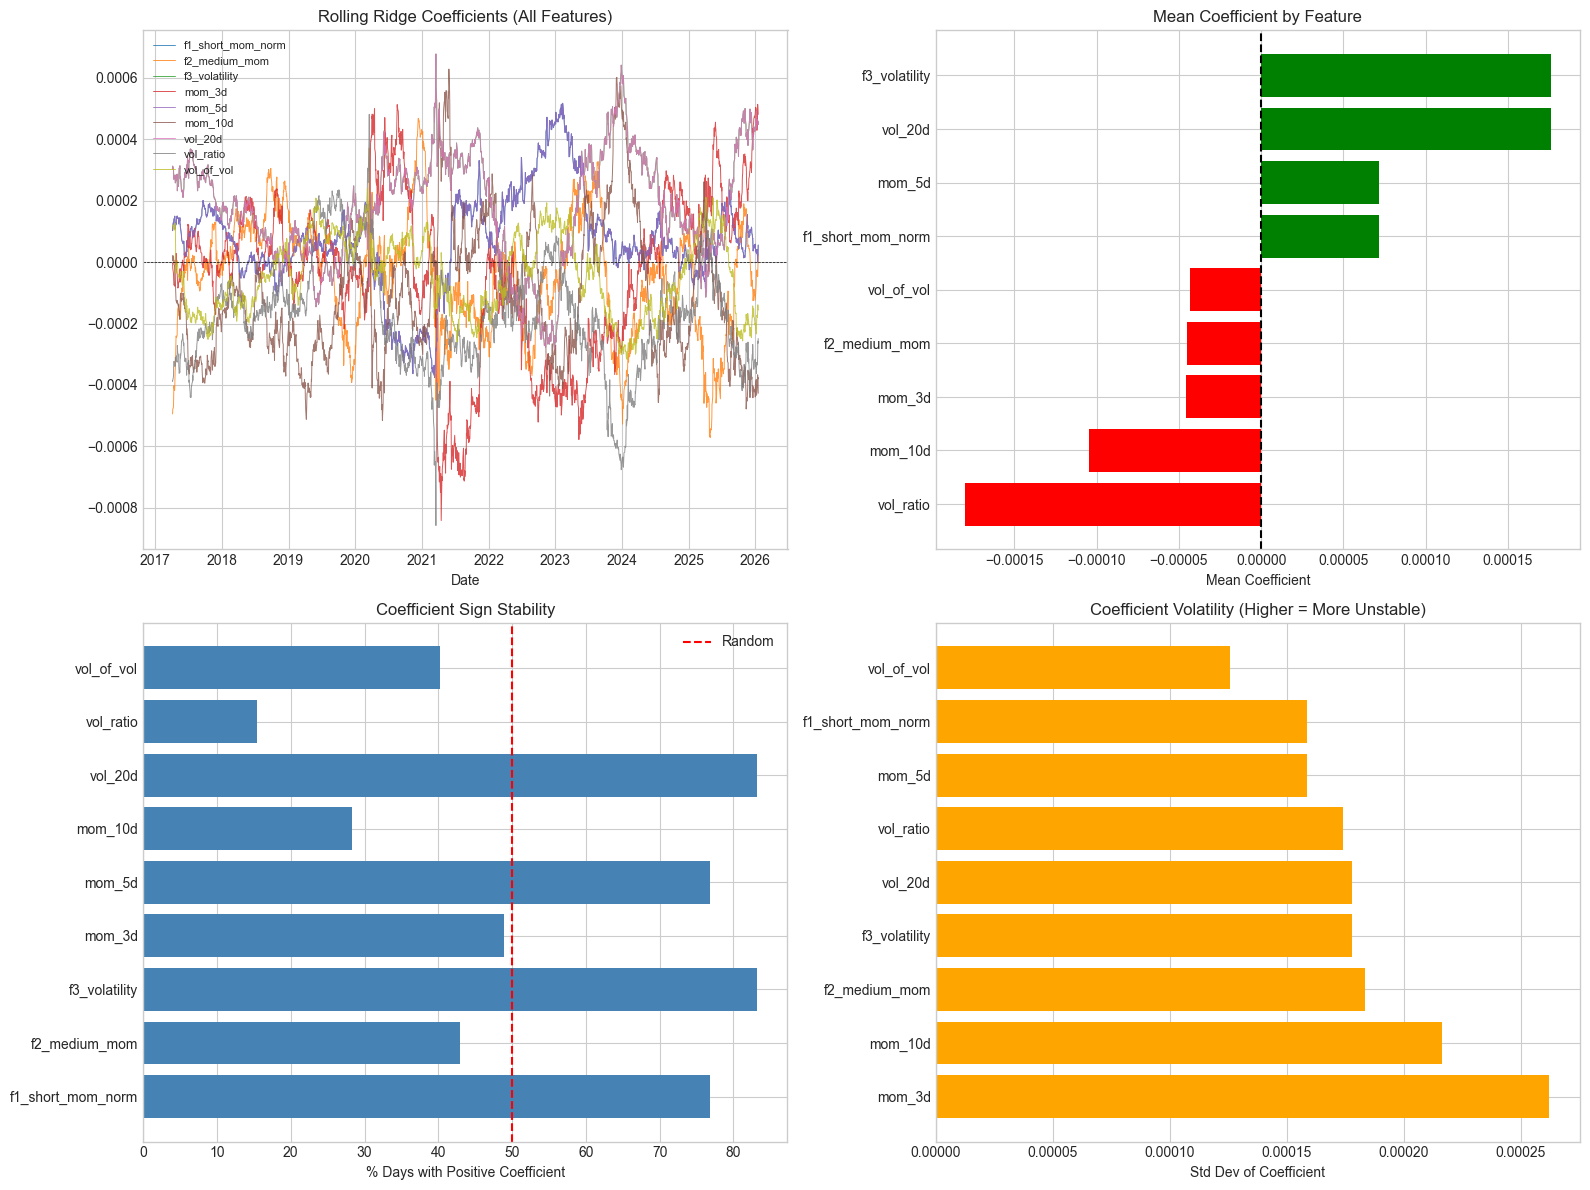


Coefficient Summary:
  vol_ratio                :  15.4% negative (STABLE), mean=-0.0002
  f3_volatility            :  83.2% positive (STABLE), mean=+0.0002
  vol_20d                  :  83.2% positive (STABLE), mean=+0.0002
  f1_short_mom_norm        :  76.9% positive (STABLE), mean=+0.0001
  mom_5d                   :  76.9% positive (STABLE), mean=+0.0001
  mom_10d                  :  28.3% negative (STABLE), mean=-0.0001
  vol_of_vol               :  40.2% negative (UNSTABLE ⚠️), mean=-0.0000
  f2_medium_mom            :  43.0% negative (UNSTABLE ⚠️), mean=-0.0000
  mom_3d                   :  48.8% negative (UNSTABLE ⚠️), mean=-0.0000


In [20]:
# Coefficient analysis for all 9 features (baseline + momentum + volatility)
coefficients_all = results_all['coefficients']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rolling coefficients over time
ax = axes[0, 0]
for col in coefficients_all.columns:
    if col != 'intercept':
        ax.plot(coefficients_all.index, coefficients_all[col], label=col, linewidth=0.7, alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Rolling Ridge Coefficients (All Features)')
ax.set_xlabel('Date')
ax.legend(loc='upper left', fontsize=8)

# 2. Mean coefficient magnitude
ax = axes[0, 1]
mean_coefs = coefficients_all.drop(columns='intercept').mean().sort_values()
colors = ['green' if x > 0 else 'red' for x in mean_coefs]
ax.barh(mean_coefs.index, mean_coefs.values, color=colors)
ax.axvline(0, color='black', linestyle='--')
ax.set_title('Mean Coefficient by Feature')
ax.set_xlabel('Mean Coefficient')

# 3. Coefficient sign stability
ax = axes[1, 0]
sign_stability_all = {}
for col in coefficients_all.columns:
    if col != 'intercept':
        coefs = coefficients_all[col].dropna()
        sign_stability_all[col] = (coefs > 0).mean() * 100

ax.barh(list(sign_stability_all.keys()), list(sign_stability_all.values()), color='steelblue')
ax.axvline(50, color='red', linestyle='--', label='Random')
ax.set_xlabel('% Days with Positive Coefficient')
ax.set_title('Coefficient Sign Stability')
ax.legend()

# 4. Coefficient volatility (instability indicator)
ax = axes[1, 1]
coef_vol = coefficients_all.drop(columns='intercept').std().sort_values(ascending=False)
ax.barh(coef_vol.index, coef_vol.values, color='orange')
ax.set_title('Coefficient Volatility (Higher = More Unstable)')
ax.set_xlabel('Std Dev of Coefficient')

plt.tight_layout()
plt.savefig('../outputs/figures/momentum/05_coefficient_analysis_all.png', dpi=150)
plt.show()

# Print summary
print("\nCoefficient Summary:")
print("=" * 60)
for col, pct in sorted(sign_stability_all.items(), key=lambda x: abs(x[1]-50), reverse=True):
    mean_val = coefficients_all[col].mean()
    stability = "STABLE" if pct > 70 or pct < 30 else "UNSTABLE ⚠️"
    direction = "positive" if pct > 50 else "negative"
    print(f"  {col:25s}: {pct:5.1f}% {direction:8s} ({stability}), mean={mean_val:+.4f}")

---

## Should We Switch to Non-Linear Models?

With 9 features (3 baseline + 3 momentum + 3 volatility), we're at the threshold where:
- Linear models may miss **interaction effects** (e.g., "momentum works better in low vol")
- LightGBM can automatically capture feature interactions
- But: More prone to overfitting, requires careful validation

Let's test LightGBM and compare!

In [21]:
import lightgbm as lgb
from sklearn.linear_model import Ridge

def run_rolling_model_comparison(features_std: dict, target: pd.DataFrame, 
                                  training_window: int = 252,
                                  verbose: bool = True) -> dict:
    """
    Compare Ridge vs LightGBM on rolling window predictions.
    Uses same data alignment for fair comparison.
    """
    feature_names = list(features_std.keys())
    dates = target.index
    assets = target.columns
    
    n_dates = len(dates)
    n_assets = len(assets)
    n_features = len(feature_names)
    
    # Pre-align data
    X_3d = np.full((n_dates, n_assets, n_features), np.nan)
    y_2d = target.values.copy()
    
    for i, fname in enumerate(feature_names):
        feat_aligned = features_std[fname].reindex(index=dates, columns=assets)
        X_3d[:, :, i] = feat_aligned.values
    
    # Storage for predictions
    pred_ridge = pd.DataFrame(index=dates, columns=assets, dtype=float)
    pred_lgb = pd.DataFrame(index=dates, columns=assets, dtype=float)
    
    start_idx = training_window + 60  # Extra warmup for LGB
    
    if verbose:
        print(f"Running model comparison from index {start_idx} to {n_dates}...")
        print(f"  Features ({n_features}): {feature_names}")
    
    # LightGBM params (conservative to avoid overfitting)
    lgb_params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'num_leaves': 15,        # Small tree
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'n_estimators': 50,      # Few trees
        'verbose': -1,
    }
    
    for t_idx in range(start_idx, n_dates):
        if verbose and t_idx % 200 == 0:
            print(f"  Processing day {t_idx}/{n_dates}...")
        
        # Extract training data
        X_window = X_3d[t_idx - training_window:t_idx].reshape(-1, n_features)
        y_window = y_2d[t_idx - training_window:t_idx].reshape(-1)
        valid_mask = ~np.isnan(X_window).any(axis=1) & ~np.isnan(y_window)
        
        if valid_mask.sum() < 500:
            continue
            
        X_train = X_window[valid_mask]
        y_train = y_window[valid_mask]
        
        # Current day prediction data
        X_pred = X_3d[t_idx]
        valid_pred = ~np.isnan(X_pred).any(axis=1)
        
        if valid_pred.sum() == 0:
            continue
        
        # Ridge prediction
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train, y_train)
        pred_ridge.iloc[t_idx, valid_pred] = ridge.predict(X_pred[valid_pred])
        
        # LightGBM prediction
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(X_train, y_train)
        pred_lgb.iloc[t_idx, valid_pred] = lgb_model.predict(X_pred[valid_pred])
    
    if verbose:
        print("Completed!")
    
    return {
        'ridge': pred_ridge.dropna(how='all'),
        'lightgbm': pred_lgb.dropna(how='all'),
        'feature_names': feature_names,
    }

print("Model comparison function defined!")

Model comparison function defined!


In [22]:
# Run Ridge vs LightGBM comparison with ALL features
# Combine baseline + momentum + volatility
all_features = {**pipeline.get_baseline_features(), **features_momentum, **features_volatility}
all_features_std = standardize_features(all_features)

print(f"Total features: {len(all_features_std)}")
model_comparison = run_rolling_model_comparison(all_features_std, pipeline.target, verbose=True)

Total features: 9
Running model comparison from index 312 to 2511...
  Features (9): ['f1_short_mom_norm', 'f2_medium_mom', 'f3_volatility', 'mom_3d', 'mom_5d', 'mom_10d', 'vol_20d', 'vol_ratio', 'vol_of_vol']
  Processing day 400/2511...
  Processing day 600/2511...
  Processing day 800/2511...
  Processing day 1000/2511...
  Processing day 1200/2511...
  Processing day 1400/2511...
  Processing day 1600/2511...
  Processing day 1800/2511...
  Processing day 2000/2511...
  Processing day 2200/2511...
  Processing day 2400/2511...
Completed!


In [25]:
# Backtest both models
from src.pipeline import construct_signals, construct_portfolio_weights, run_backtest, compute_all_metrics

def backtest_predictions(predictions: pd.DataFrame, returns: pd.DataFrame, params: dict) -> dict:
    """Quick backtest from predictions."""
    signals, signal_ranks = construct_signals(predictions)
    weights = construct_portfolio_weights(signal_ranks, params)
    backtest = run_backtest(weights, returns, params)
    metrics = compute_all_metrics(backtest)
    return {'backtest': backtest, 'metrics': metrics}

# Backtest Ridge
results_ridge = backtest_predictions(model_comparison['ridge'], panel['returns'], DEFAULT_PARAMS)

# Backtest LightGBM
results_lgb = backtest_predictions(model_comparison['lightgbm'], panel['returns'], DEFAULT_PARAMS)

# Compare
print("\n" + "=" * 70)
print("MODEL COMPARISON: Ridge vs LightGBM (9 features)")
print("=" * 70)
print(f"{'Metric':<25} {'Ridge':>15} {'LightGBM':>15} {'Delta':>15}")
print("-" * 70)

metrics_to_show = [
    ('Gross Sharpe', 'gross', 'sharpe'),
    ('Net Sharpe', 'net', 'sharpe'),
    ('Annual Return', 'net', 'ann_return'),
    ('Max Drawdown', 'net', 'max_dd'),
    ('Turnover', 'gross', 'ann_turnover'),
]

for name, level, metric in metrics_to_show:
    ridge_val = results_ridge['metrics'][level][metric]
    lgb_val = results_lgb['metrics'][level][metric]
    delta = lgb_val - ridge_val
    
    if metric in ['ann_return', 'max_dd']:
        print(f"{name:<25} {ridge_val*100:>14.2f}% {lgb_val*100:>14.2f}% {delta*100:>+14.2f}%")
    elif metric == 'ann_turnover':
        print(f"{name:<25} {ridge_val:>14.1f}x {lgb_val:>14.1f}x {delta:>+14.1f}x")
    else:
        print(f"{name:<25} {ridge_val:>15.4f} {lgb_val:>15.4f} {delta:>+15.4f}")

print("-" * 70)
if results_lgb['metrics']['gross']['sharpe'] > results_ridge['metrics']['gross']['sharpe']:
    print("✅ LightGBM OUTPERFORMS Ridge!")
else:
    print("⚠️  Ridge still competitive - keep using linear model")


MODEL COMPARISON: Ridge vs LightGBM (9 features)
Metric                              Ridge        LightGBM           Delta
----------------------------------------------------------------------
Gross Sharpe                      -0.0280         -0.0370         -0.0090
Net Sharpe                        -0.8886         -2.1142         -1.2255
Annual Return                     -15.05%         -27.00%         -11.95%
Max Drawdown                      -82.83%         -92.36%          -9.53%
Turnover                           145.7x          265.2x         +119.5x
----------------------------------------------------------------------
⚠️  Ridge still competitive - keep using linear model


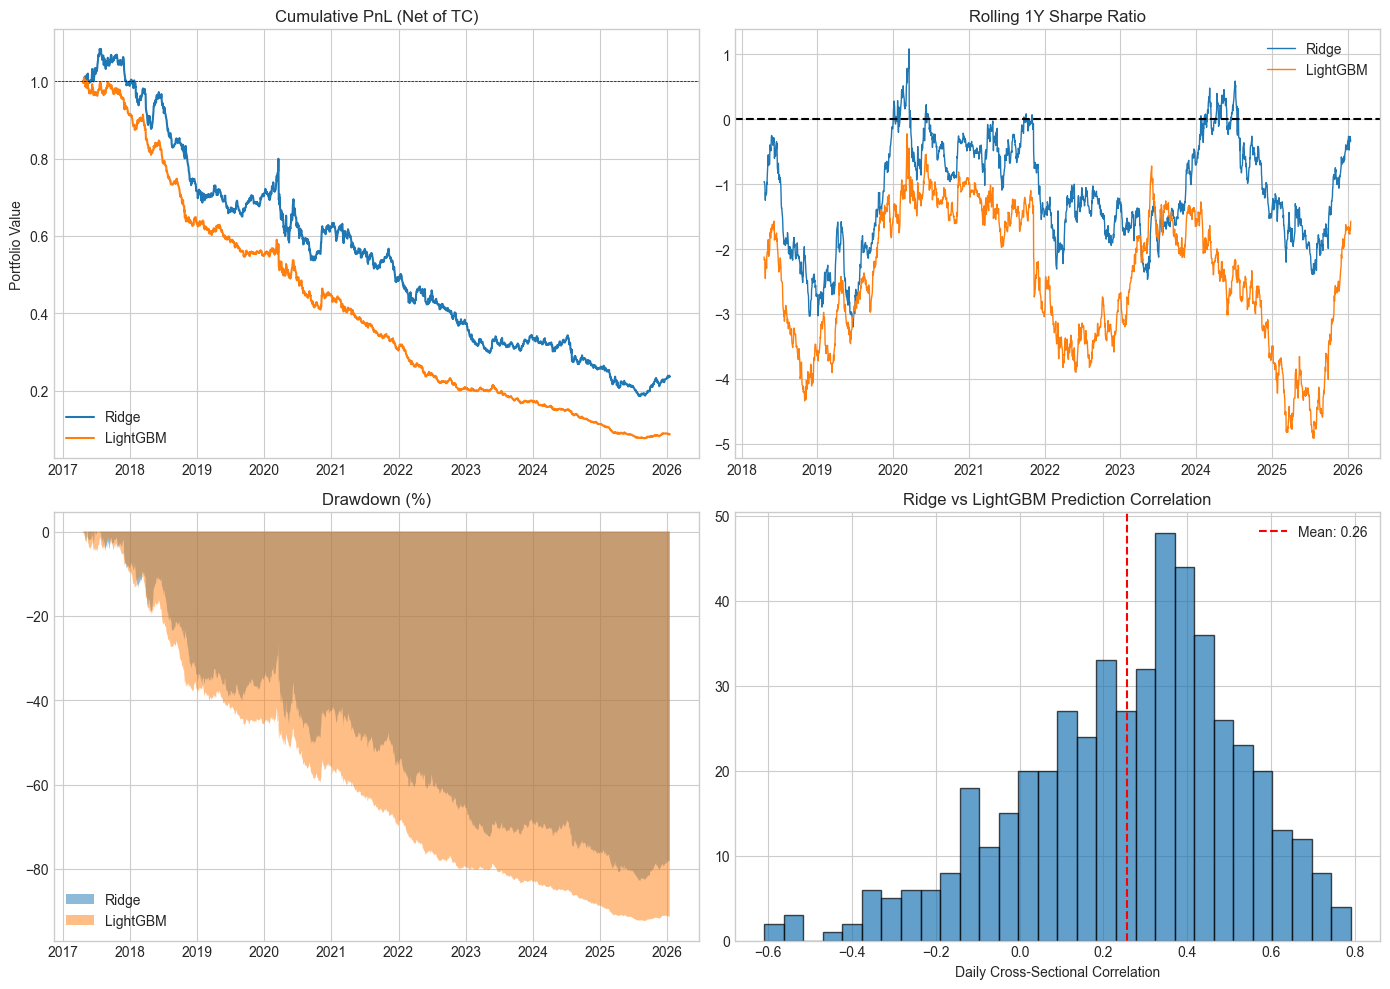


Prediction correlation: 0.256
💡 LOW CORRELATION: Models see different patterns - good for ensembling!


In [26]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative PnL
ax = axes[0, 0]
ridge_cum = (1 + results_ridge['backtest']['net_returns']).cumprod()
lgb_cum = (1 + results_lgb['backtest']['net_returns']).cumprod()
common = ridge_cum.index.intersection(lgb_cum.index)
ax.plot(common, ridge_cum.loc[common], label='Ridge', linewidth=1.5)
ax.plot(common, lgb_cum.loc[common], label='LightGBM', linewidth=1.5)
ax.axhline(1, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Cumulative PnL (Net of TC)')
ax.legend()
ax.set_ylabel('Portfolio Value')

# 2. Rolling Sharpe
ax = axes[0, 1]
window = 252
ridge_sharpe = (results_ridge['backtest']['net_returns'].rolling(window).mean() / 
                results_ridge['backtest']['net_returns'].rolling(window).std() * np.sqrt(252))
lgb_sharpe = (results_lgb['backtest']['net_returns'].rolling(window).mean() / 
              results_lgb['backtest']['net_returns'].rolling(window).std() * np.sqrt(252))
ax.plot(ridge_sharpe.index, ridge_sharpe, label='Ridge', linewidth=1)
ax.plot(lgb_sharpe.index, lgb_sharpe, label='LightGBM', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Rolling 1Y Sharpe Ratio')
ax.legend()

# 3. Drawdown comparison
ax = axes[1, 0]
ridge_dd = (ridge_cum / ridge_cum.cummax() - 1) * 100
lgb_dd = (lgb_cum / lgb_cum.cummax() - 1) * 100
ax.fill_between(ridge_dd.index, ridge_dd, 0, alpha=0.5, label='Ridge')
ax.fill_between(lgb_dd.index, lgb_dd, 0, alpha=0.5, label='LightGBM')
ax.set_title('Drawdown (%)')
ax.legend()

# 4. Prediction correlation (are models making similar predictions?)
ax = axes[1, 1]
pred_corr = []
for date in common[:500]:  # Sample for speed
    r = model_comparison['ridge'].loc[date].dropna()
    l = model_comparison['lightgbm'].loc[date].dropna()
    common_assets = r.index.intersection(l.index)
    if len(common_assets) > 10:
        pred_corr.append(np.corrcoef(r[common_assets], l[common_assets])[0, 1])

ax.hist(pred_corr, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(pred_corr), color='red', linestyle='--', label=f'Mean: {np.mean(pred_corr):.2f}')
ax.set_title('Ridge vs LightGBM Prediction Correlation')
ax.set_xlabel('Daily Cross-Sectional Correlation')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/momentum/06_ridge_vs_lightgbm.png', dpi=150)
plt.show()

print(f"\nPrediction correlation: {np.mean(pred_corr):.3f}")
if np.mean(pred_corr) < 0.5:
    print("💡 LOW CORRELATION: Models see different patterns - good for ensembling!")
else:
    print("📊 HIGH CORRELATION: Models agree - LightGBM may not add much")

---

## Key Findings & Next Steps

### Results Summary

| Model | Gross Sharpe | Turnover | Verdict |
|-------|-------------|----------|---------|
| Baseline (3 features) | 0.0292 | 112x | ✅ Benchmark |
| Baseline + Momentum (6 features) | **0.0384** | 157x | 👑 **BEST** |
| Baseline + Momentum + Vol (9 features) | -0.0384 | 146x | ❌ Degraded |
| LightGBM (9 features) | -0.0370 | 265x | ❌ Worse + high turnover |

### Key Insights

1. **Volatility features HURT performance** in direct signal form
   - `vol_ratio` has strong negative mean coefficient (consistently wrong direction)
   - Volatility is a **state variable**, not a direct predictor
   
2. **LightGBM underperforms Ridge**
   - 2x higher turnover → transaction cost killer
   - Non-linear doesn't help when signal is weak
   
3. **Low prediction correlation (0.26)** between Ridge and LightGBM
   - Different patterns, but both wrong!
   - Not a good ensembling opportunity YET

### Recommended Path Forward

1. **Keep Baseline + Momentum only** (best performer)
2. **Volatility as interaction terms**, not direct features:
   - `mom_5d × low_vol_indicator` (momentum works better in low vol?)
   - Or use for **gating**: only trade when vol_ratio < 1
3. **Try Mean Reversion block** instead of more volatility

## Experiment: Volatility as Gating/Interaction, Not Direct Feature

**Hypothesis**: Volatility isn't a directional predictor—it's a *state variable* that modulates how other signals work.

Instead of: `y ~ mom_5d + vol_20d`  
Try: `y ~ mom_5d + mom_5d × high_vol_indicator`

This tests whether momentum behaves differently in high/low volatility regimes.

---

# Part 4: Trend-Based Regime Conditioning

**Key Insight from Previous Work**: Volatility features hurt performance when used as direct predictors. They are *state variables*, not signals.

## The Same Logic Applies to Trends

Trends are **observed states**, not targets. We use them to *modulate* how signals work.

### Three Minimal Trend Features (All We Need)

1. **Market Trend Strength** (60d, vol-normalized)
   $$\text{Trend}_t = \frac{\sum_{k=1}^{60} r_{t-k}^m}{\sigma_{t,60}^m}$$

2. **Trend Consistency** (sign agreement)
   $$\text{TrendConsistency}_t = \frac{1}{60} \sum_{k=1}^{60} \mathbf{1}(\text{sign}(r_{t-k}^m) = \text{sign}(\text{Trend}_t))$$

3. **Trend Breadth** (cross-sectional agreement)
   $$\text{Breadth}_t = \frac{1}{N} \sum_i \mathbf{1}\left(\sum_{k=1}^{20} r_{i,t-k} > 0\right)$$

### The Regime Matrix

| Trend | Dispersion | Interpretation |
|-------|-----------|----------------|
| Strong | High | Healthy trend → momentum-friendly |
| Strong | Low | Index flow → fragile |
| Weak | High | Relative-value regime |
| Weak | Low | Noise / no-trade |

In [27]:
# =============================================================================
# TREND REGIME FEATURE ENGINEERING
# =============================================================================
# These are STATE VARIABLES, not direct predictors

def compute_trend_features(returns: pd.DataFrame, trend_window: int = 60, breadth_window: int = 20) -> dict:
    """
    Compute 3 minimal trend regime features:
    1. Market trend strength (vol-normalized)
    2. Trend consistency (sign agreement)
    3. Trend breadth (cross-sectional)
    
    Parameters:
    -----------
    returns : pd.DataFrame
        Daily returns, shape (T, N)
    trend_window : int
        Window for trend calculation (default 60 days ≈ 3 months)
    breadth_window : int
        Window for breadth calculation (default 20 days ≈ 1 month)
    
    Returns:
    --------
    dict with 'trend_strength', 'trend_consistency', 'trend_breadth' as Series
    """
    
    # Market return (equal-weight across all stocks)
    market_ret = returns.mean(axis=1)
    
    # 1. MARKET TREND STRENGTH (vol-normalized)
    # Trend_t = sum(r_{t-k}^m for k=1..60) / sigma_{t,60}^m
    cumret_60 = market_ret.rolling(trend_window).sum()
    vol_60 = market_ret.rolling(trend_window).std() * np.sqrt(trend_window)
    trend_strength = cumret_60 / vol_60.replace(0, np.nan)
    
    # 2. TREND CONSISTENCY (sign agreement)
    # What fraction of the last 60 days had returns in the same direction as the trend?
    trend_sign = np.sign(trend_strength)
    
    def calc_consistency(idx):
        """Calculate consistency for a single date"""
        if pd.isna(trend_sign.loc[idx]):
            return np.nan
        # Get the last 60 days of returns
        start_idx = returns.index.get_loc(idx) - trend_window + 1
        if start_idx < 0:
            return np.nan
        end_idx = returns.index.get_loc(idx) + 1
        ret_slice = market_ret.iloc[start_idx:end_idx]
        # Count days where return sign matches trend sign
        matching = (np.sign(ret_slice) == trend_sign.loc[idx]).sum()
        return matching / len(ret_slice)
    
    # Vectorized consistency calculation (faster)
    ret_sign = np.sign(market_ret)
    # Rolling count of positive days
    pos_count = (market_ret > 0).rolling(trend_window).sum()
    neg_count = (market_ret < 0).rolling(trend_window).sum()
    # If trend is positive, consistency = pos_count / 60
    # If trend is negative, consistency = neg_count / 60
    trend_consistency = np.where(
        trend_sign > 0,
        pos_count / trend_window,
        np.where(trend_sign < 0, neg_count / trend_window, 0.5)
    )
    trend_consistency = pd.Series(trend_consistency, index=returns.index)
    
    # 3. TREND BREADTH (cross-sectional)
    # Fraction of stocks with positive 20d cumulative return
    cumret_20d = returns.rolling(breadth_window).sum()
    trend_breadth = (cumret_20d > 0).mean(axis=1)
    
    return {
        'trend_strength': trend_strength,
        'trend_consistency': trend_consistency,
        'trend_breadth': trend_breadth
    }

# Compute trend features
print("Computing trend regime features...")
trend_features = compute_trend_features(returns, trend_window=60, breadth_window=20)

for name, feat in trend_features.items():
    valid = feat.dropna()
    print(f"  {name}: mean={valid.mean():.4f}, std={valid.std():.4f}, range=[{valid.min():.3f}, {valid.max():.3f}]")

Computing trend regime features...
  trend_strength: mean=0.9152, std=0.9173, range=[-1.768, 3.765]
  trend_consistency: mean=0.5661, std=0.0602, range=[0.383, 0.750]
  trend_breadth: mean=0.6032, std=0.2180, range=[0.000, 1.000]


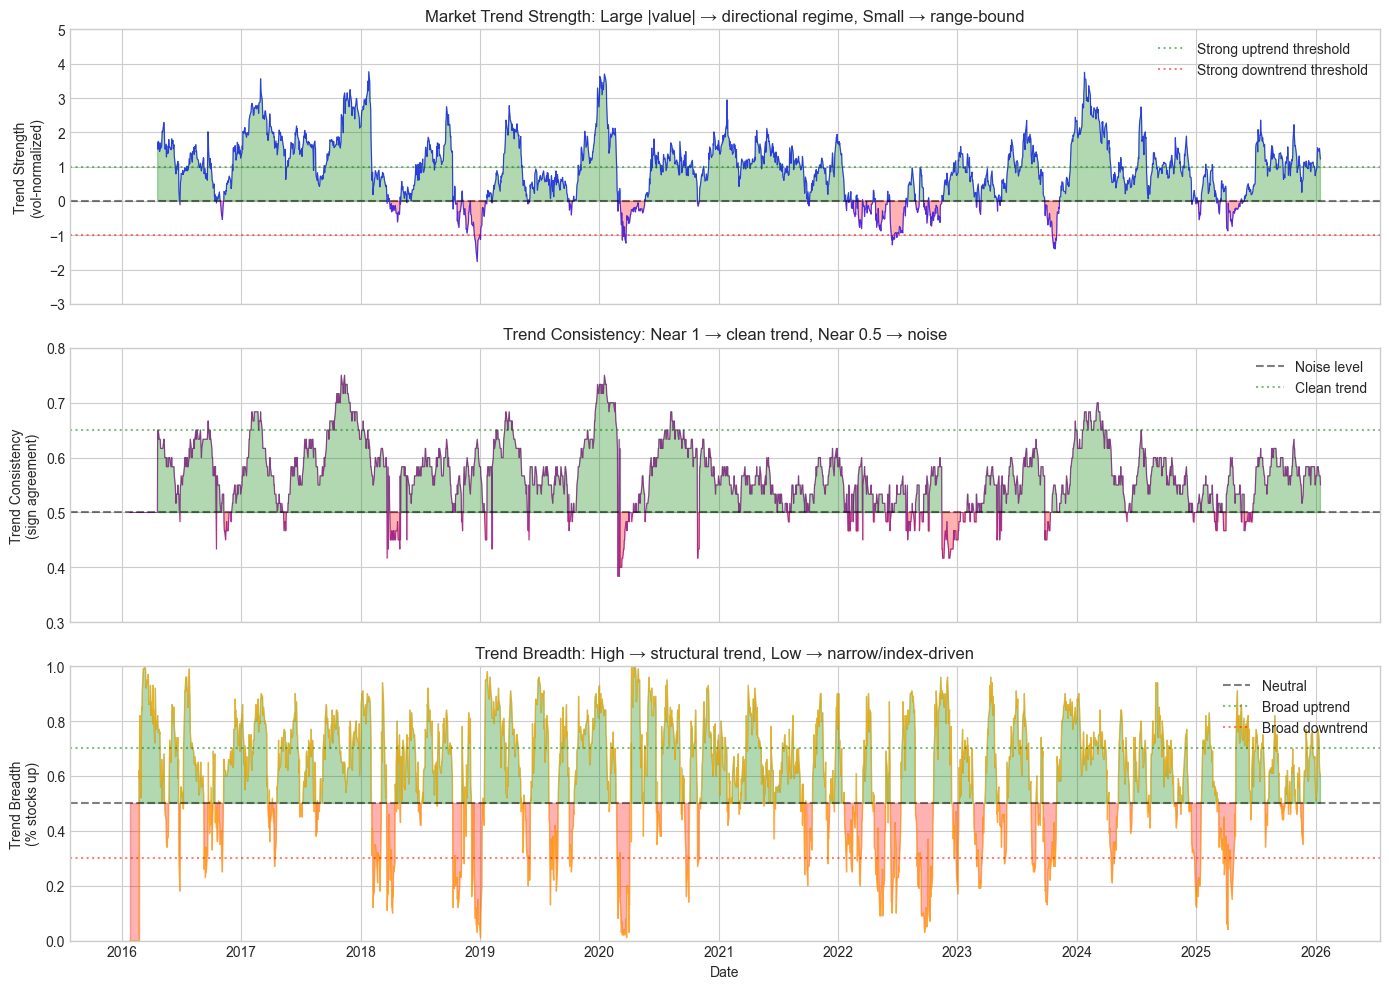


📊 Trend Regime Summary:
  Strong uptrend days (trend > 1): 1109 (45.2%)
  Strong downtrend days (trend < -1): 33 (1.3%)
  Range-bound days (|trend| < 1): 1309 (53.4%)
  Clean trend days (consistency > 0.6): 554 (22.1%)
  Broad market days (breadth > 0.6): 1459 (58.1%)


In [28]:
# Visualize trend regime features
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Trend Strength
ax = axes[0]
ts = trend_features['trend_strength'].dropna()
ax.plot(ts.index, ts.values, 'b-', alpha=0.7, linewidth=0.8)
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.axhline(1, color='g', linestyle=':', alpha=0.5, label='Strong uptrend threshold')
ax.axhline(-1, color='r', linestyle=':', alpha=0.5, label='Strong downtrend threshold')
ax.fill_between(ts.index, 0, ts.values, where=ts.values > 0, alpha=0.3, color='green')
ax.fill_between(ts.index, 0, ts.values, where=ts.values < 0, alpha=0.3, color='red')
ax.set_ylabel('Trend Strength\n(vol-normalized)')
ax.set_title('Market Trend Strength: Large |value| → directional regime, Small → range-bound')
ax.legend(loc='upper right')
ax.set_ylim(-3, 5)

# 2. Trend Consistency
ax = axes[1]
tc = trend_features['trend_consistency'].dropna()
ax.plot(tc.index, tc.values, 'purple', alpha=0.7, linewidth=0.8)
ax.axhline(0.5, color='k', linestyle='--', alpha=0.5, label='Noise level')
ax.axhline(0.65, color='g', linestyle=':', alpha=0.5, label='Clean trend')
ax.fill_between(tc.index, 0.5, tc.values, where=tc.values > 0.5, alpha=0.3, color='green')
ax.fill_between(tc.index, 0.5, tc.values, where=tc.values < 0.5, alpha=0.3, color='red')
ax.set_ylabel('Trend Consistency\n(sign agreement)')
ax.set_title('Trend Consistency: Near 1 → clean trend, Near 0.5 → noise')
ax.legend(loc='upper right')
ax.set_ylim(0.3, 0.8)

# 3. Trend Breadth  
ax = axes[2]
tb = trend_features['trend_breadth'].dropna()
ax.plot(tb.index, tb.values, 'orange', alpha=0.7, linewidth=0.8)
ax.axhline(0.5, color='k', linestyle='--', alpha=0.5, label='Neutral')
ax.axhline(0.7, color='g', linestyle=':', alpha=0.5, label='Broad uptrend')
ax.axhline(0.3, color='r', linestyle=':', alpha=0.5, label='Broad downtrend')
ax.fill_between(tb.index, 0.5, tb.values, where=tb.values > 0.5, alpha=0.3, color='green')
ax.fill_between(tb.index, 0.5, tb.values, where=tb.values < 0.5, alpha=0.3, color='red')
ax.set_ylabel('Trend Breadth\n(% stocks up)')
ax.set_xlabel('Date')
ax.set_title('Trend Breadth: High → structural trend, Low → narrow/index-driven')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../outputs/trend_regime_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Trend Regime Summary:")
print(f"  Strong uptrend days (trend > 1): {(ts > 1).sum()} ({100*(ts > 1).mean():.1f}%)")
print(f"  Strong downtrend days (trend < -1): {(ts < -1).sum()} ({100*(ts < -1).mean():.1f}%)")
print(f"  Range-bound days (|trend| < 1): {(abs(ts) < 1).sum()} ({100*(abs(ts) < 1).mean():.1f}%)")
print(f"  Clean trend days (consistency > 0.6): {(tc > 0.6).sum()} ({100*(tc > 0.6).mean():.1f}%)")
print(f"  Broad market days (breadth > 0.6): {(tb > 0.6).sum()} ({100*(tb > 0.6).mean():.1f}%)")

📊 Regime Distribution:
  Relative Value: 773 days (30.8%)
  Index Flow: 690 days (27.5%)
  No Trade: 596 days (23.7%)
  Healthy Trend: 452 days (18.0%)


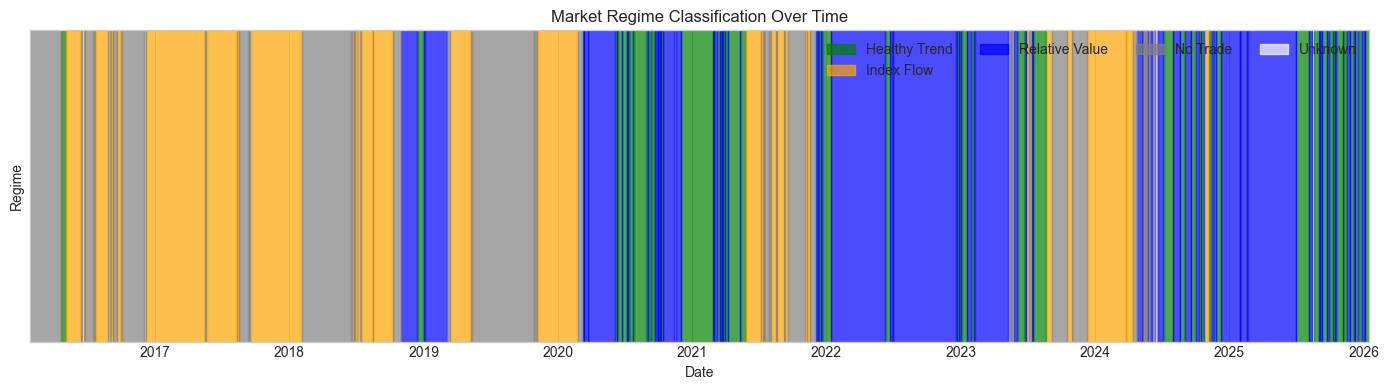

In [29]:
# =============================================================================
# DISPERSION-TREND INTERACTION (The Regime Matrix)
# =============================================================================
# Compute cross-sectional dispersion for the interaction analysis

# Cross-sectional dispersion (std of returns across stocks)
dispersion = returns.std(axis=1)
dispersion_60d = dispersion.rolling(60).mean()  # Smoothed dispersion

# Create regime classifications
trend = trend_features['trend_strength']
strong_trend = abs(trend) > 1
high_dispersion = dispersion_60d > dispersion_60d.median()

# Create 2x2 regime matrix
regimes = pd.DataFrame(index=returns.index)
regimes['trend_strong'] = strong_trend
regimes['disp_high'] = high_dispersion
regimes['regime'] = 'Unknown'
regimes.loc[strong_trend & high_dispersion, 'regime'] = 'Healthy Trend'
regimes.loc[strong_trend & ~high_dispersion, 'regime'] = 'Index Flow'
regimes.loc[~strong_trend & high_dispersion, 'regime'] = 'Relative Value'
regimes.loc[~strong_trend & ~high_dispersion, 'regime'] = 'No Trade'

# Count regime frequencies
regime_counts = regimes['regime'].value_counts()
print("📊 Regime Distribution:")
for r, count in regime_counts.items():
    pct = 100 * count / len(regimes)
    print(f"  {r}: {count} days ({pct:.1f}%)")

# Visualize regime over time
fig, ax = plt.subplots(figsize=(14, 4))
regime_colors = {
    'Healthy Trend': 'green',
    'Index Flow': 'orange', 
    'Relative Value': 'blue',
    'No Trade': 'gray',
    'Unknown': 'white'
}
for i, (r, color) in enumerate(regime_colors.items()):
    mask = regimes['regime'] == r
    ax.fill_between(regimes.index, 0, 1, where=mask, alpha=0.7, color=color, label=r)
ax.set_xlim(regimes.index.min(), regimes.index.max())
ax.set_ylim(0, 1)
ax.set_ylabel('Regime')
ax.set_xlabel('Date')
ax.set_title('Market Regime Classification Over Time')
ax.legend(loc='upper right', ncol=4)
ax.set_yticks([])
plt.tight_layout()
plt.savefig('../outputs/regime_classification.png', dpi=150, bbox_inches='tight')
plt.show()

## Building Regime-Conditioned Feature Set

**Strategy**: Use regime features to *modulate* momentum signals, not as direct predictors.

**Interaction Features**:
- `mom_5d × trend_strength` → Momentum scaled by trend confidence
- `mom_5d × trend_consistency` → Momentum only when trend is clean
- `mom_5d × trend_breadth` → Momentum only when broad participation

This lets the model learn: "Momentum works *when* trend is strong AND consistent AND broad"

In [30]:
# =============================================================================
# BUILD REGIME-CONDITIONED FEATURE SET
# =============================================================================

def build_regime_features(returns: pd.DataFrame, trend_features: dict) -> dict:
    """
    Build features with regime conditioning:
    1. Base features (momentum)
    2. Regime state variables (for soft gating, not direct prediction)
    3. Interaction terms (momentum × regime)
    """
    
    # Extract trend regime variables (these are market-level, broadcast to all stocks)
    trend_strength = trend_features['trend_strength']
    trend_consistency = trend_features['trend_consistency']
    trend_breadth = trend_features['trend_breadth']
    
    features = {}
    
    # --- BASELINE FEATURES ---
    features['ret_1d'] = returns.shift(1)  # Yesterday's return
    features['ret_5d'] = returns.rolling(5).sum().shift(1)  # 5-day momentum
    features['vol_20d'] = returns.rolling(20).std().shift(1)  # 20-day volatility
    
    # --- MOMENTUM FEATURES ---
    features['mom_3d'] = returns.rolling(3).sum().shift(1)
    features['mom_5d'] = returns.rolling(5).sum().shift(1)
    features['mom_10d'] = returns.rolling(10).sum().shift(1)
    
    # --- REGIME STATE VARIABLES (broadcast to panel) ---
    # These are market-level, so we broadcast to all stocks
    features['trend_strength'] = pd.DataFrame(
        np.tile(trend_strength.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    features['trend_consistency'] = pd.DataFrame(
        np.tile(trend_consistency.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    features['trend_breadth'] = pd.DataFrame(
        np.tile(trend_breadth.values.reshape(-1, 1), (1, returns.shape[1])),
        index=returns.index, columns=returns.columns
    )
    
    # --- INTERACTION TERMS (The Key Innovation) ---
    # Momentum × Regime = Conditional momentum
    features['mom_5d_x_trend'] = features['mom_5d'] * features['trend_strength']
    features['mom_5d_x_consistency'] = features['mom_5d'] * features['trend_consistency']
    features['mom_5d_x_breadth'] = features['mom_5d'] * features['trend_breadth']
    
    # Standardize all features
    for name in features:
        features[name] = (features[name] - features[name].expanding().mean()) / features[name].expanding().std()
    
    return features

# Build the full feature set
print("Building regime-conditioned features...")
regime_features = build_regime_features(returns, trend_features)

print(f"\n📊 Feature Set ({len(regime_features)} features):")
for name in regime_features:
    df = regime_features[name]
    valid = df.values[~np.isnan(df.values)]
    print(f"  {name}: shape={df.shape}, valid={len(valid):,}")

Building regime-conditioned features...

📊 Feature Set (12 features):
  ret_1d: shape=(2511, 100), valid=250,800
  ret_5d: shape=(2511, 100), valid=250,400
  vol_20d: shape=(2511, 100), valid=248,900
  mom_3d: shape=(2511, 100), valid=250,600
  mom_5d: shape=(2511, 100), valid=250,400
  mom_10d: shape=(2511, 100), valid=249,900
  trend_strength: shape=(2511, 100), valid=245,000
  trend_consistency: shape=(2511, 100), valid=245,100
  trend_breadth: shape=(2511, 100), valid=249,100
  mom_5d_x_trend: shape=(2511, 100), valid=245,000
  mom_5d_x_consistency: shape=(2511, 100), valid=250,400
  mom_5d_x_breadth: shape=(2511, 100), valid=249,100


## Multi-Model Comparison: Ridge vs LightGBM vs MLP

Now we test three model families on the regime-conditioned features:

1. **Ridge Regression** (Linear) - Baseline, interpretable
2. **LightGBM** (Gradient Boosting) - Non-linear, handles interactions naturally
3. **MLP** (Neural Network) - Deep non-linear, can learn complex patterns

**Hypothesis**: Regime-conditioned features should help *all* models, but non-linear models may extract more value from the interactions.

In [66]:
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (4.1 MB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import torch
torch.cuda.is_available()


True

In [32]:
# =============================================================================
# MULTI-MODEL FRAMEWORK: Ridge, LightGBM, MLP
# =============================================================================
import lightgbm as lgb
import torch
import torch.nn as nn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

class MLPModel(nn.Module):
    """Simple MLP for return prediction"""
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.BatchNorm1d(h_dim)
            ])
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze(-1)

def train_mlp(X_train, y_train, hidden_dims=[64, 32], epochs=100, lr=0.001, batch_size=1024, verbose=False):
    """Train MLP model on GPU if available"""
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train).to(device)
    y_tensor = torch.FloatTensor(y_train).to(device)
    
    # Create model
    model = MLPModel(X_train.shape[1], hidden_dims).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    # Training loop
    model.train()
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")
    
    return model

def predict_mlp(model, X):
    """Predict with MLP model"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        pred = model(X_tensor).cpu().numpy()
    return pred

print("✅ Multi-model framework ready")

🖥️ Device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
✅ Multi-model framework ready


In [35]:
# =============================================================================
# COMPLETE MULTI-MODEL ROLLING BACKTEST WITH MODEL SAVING
# =============================================================================
# OPTIMIZED: Retrain every 21 days (monthly) instead of daily
# This is ~100x faster while still capturing market regime changes
import os
import pickle
import joblib
from datetime import datetime

# Create models directory
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

def run_multi_model_backtest(
    features: dict,
    returns: pd.DataFrame,
    train_window: int = 252,
    retrain_interval: int = 21,  # NEW: Only retrain every N days
    top_pct: float = 0.2,
    transaction_cost: float = 0.001,
    save_models: bool = True,
    model_prefix: str = 'regime_conditioned',
    progress_every: int = 50,  # Show progress every N days
    use_gpu_mlp: bool = False  # CPU is faster for small MLPs
):
    """
    Run rolling backtest with Ridge, LightGBM, and MLP models.
    
    Key optimization: Only retrain models every `retrain_interval` days.
    - Daily retraining: ~2000 model fits (very slow)
    - Monthly retraining (21d): ~100 model fits (fast)
    
    For small MLPs, CPU is actually faster than GPU due to memory transfer overhead.
    """
    
    feature_names = list(features.keys())
    n_features = len(feature_names)
    
    print("=" * 70)
    print("🚀 MULTI-MODEL BACKTEST WITH REGIME-CONDITIONED FEATURES")
    print("=" * 70)
    print(f"\n📊 Features ({n_features} total):")
    for f in feature_names:
        print(f"   • {f}")
    
    # Prepare aligned data
    common_dates = returns.index
    for f in features.values():
        common_dates = common_dates.intersection(f.dropna(how='all').index)
    common_dates = sorted(common_dates)
    
    common_assets = returns.columns
    for f in features.values():
        common_assets = common_assets.intersection(f.columns)
    
    # Build 3D array: (T, N, F)
    T = len(common_dates)
    N = len(common_assets)
    F = n_features
    
    X_panel = np.zeros((T, N, F))
    for fi, fname in enumerate(feature_names):
        X_panel[:, :, fi] = features[fname].loc[common_dates, common_assets].values
    
    y_panel = returns.loc[common_dates, common_assets].values
    
    print(f"\n📐 Data Dimensions:")
    print(f"   • Time:   {T} days ({common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')})")
    print(f"   • Assets: {N} stocks")
    print(f"   • Features: {F}")
    
    print(f"\n⚙️ Training Configuration:")
    print(f"   • Training window: {train_window} days (~{train_window//21} months)")
    print(f"   • Retrain interval: {retrain_interval} days (models updated every ~{retrain_interval} days)")
    print(f"   • Test period: {T - train_window} days")
    
    n_retrains = (T - train_window) // retrain_interval + 1
    print(f"   • Expected retrains: {n_retrains} (vs {T - train_window} if daily)")
    print(f"   • MLP device: {'GPU' if use_gpu_mlp else 'CPU (faster for small models)'}")
    
    # Initialize prediction storage
    preds_ridge = pd.DataFrame(index=common_dates[train_window:], columns=common_assets, dtype=float)
    preds_lgb = pd.DataFrame(index=common_dates[train_window:], columns=common_assets, dtype=float)
    preds_mlp = pd.DataFrame(index=common_dates[train_window:], columns=common_assets, dtype=float)
    
    # Model storage for saving
    saved_models = {'ridge': [], 'lgb': [], 'mlp': []}
    save_frequency = 63  # Save every quarter
    
    # Current models (reused between retrains)
    current_ridge = None
    current_lgb = None
    current_mlp = None
    
    # Stats tracking
    retrain_count = 0
    
    print(f"\n" + "=" * 70)
    print("📈 TRAINING PROGRESS")
    print("=" * 70)
    
    start_time = datetime.now()
    
    for t in range(train_window, T):
        day_idx = t - train_window
        date = common_dates[t]
        
        # Check if we need to retrain
        need_retrain = (day_idx % retrain_interval == 0) or (current_ridge is None)
        
        if need_retrain:
            retrain_count += 1
            
            # Training data: last train_window days, all assets pooled
            X_train_3d = X_panel[t-train_window:t, :, :]  # (train_window, N, F)
            y_train_2d = y_panel[t-train_window:t, :]      # (train_window, N)
            
            # Flatten for training
            X_train = X_train_3d.reshape(-1, F)
            y_train = y_train_2d.flatten()
            
            # Remove NaN rows
            valid_mask = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
            X_train = X_train[valid_mask]
            y_train = y_train[valid_mask]
            
            if len(X_train) < 100:
                continue
            
            # --- RETRAIN ALL MODELS ---
            # Ridge
            current_ridge = Ridge(alpha=1.0)
            current_ridge.fit(X_train, y_train)
            
            # LightGBM
            current_lgb = lgb.LGBMRegressor(
                n_estimators=50,
                max_depth=3,
                learning_rate=0.1,
                min_child_samples=100,
                subsample=0.8,
                colsample_bytree=0.8,
                verbosity=-1,
                force_row_wise=True,
                n_jobs=-1  # Use all cores
            )
            current_lgb.fit(X_train, y_train)
            
            # MLP (use CPU for speed with small models)
            mlp_device = device if use_gpu_mlp else torch.device('cpu')
            current_mlp = train_mlp_fast(X_train, y_train, mlp_device, 
                                         hidden_dims=[64, 32], epochs=30, lr=0.001)
            
            # Save models periodically
            if save_models and retrain_count % (save_frequency // retrain_interval + 1) == 0:
                model_date = date.strftime('%Y%m%d')
                saved_models['ridge'].append((model_date, current_ridge))
                saved_models['lgb'].append((model_date, current_lgb))
                saved_models['mlp'].append((model_date, current_mlp.state_dict()))
        
        # --- PREDICT WITH CURRENT MODELS ---
        X_test = X_panel[t, :, :]  # (N, F)
        valid_test = ~np.isnan(X_test).any(axis=1)
        
        # Ridge prediction
        ridge_pred = current_ridge.predict(X_test)
        ridge_pred[~valid_test] = np.nan
        preds_ridge.loc[date] = ridge_pred
        
        # LightGBM prediction
        lgb_pred = current_lgb.predict(X_test)
        lgb_pred[~valid_test] = np.nan
        preds_lgb.loc[date] = lgb_pred
        
        # MLP prediction
        mlp_pred = predict_mlp_fast(current_mlp, X_test, device if use_gpu_mlp else torch.device('cpu'))
        mlp_pred[~valid_test] = np.nan
        preds_mlp.loc[date] = mlp_pred
        
        # Progress reporting
        if (day_idx + 1) % progress_every == 0 or day_idx == 0:
            elapsed = (datetime.now() - start_time).total_seconds()
            done = day_idx + 1
            total = T - train_window
            pct = 100 * done / total
            eta = elapsed / done * (total - done) if done > 0 else 0
            
            # Calculate speed metrics
            days_per_sec = done / elapsed if elapsed > 0 else 0
            
            status = "🔄 RETRAIN" if need_retrain else "→ predict"
            print(f"   Day {done:4d}/{total} ({pct:5.1f}%) | {status} | "
                  f"Retrains: {retrain_count:3d} | "
                  f"Speed: {days_per_sec:.1f} days/s | "
                  f"Elapsed: {elapsed:6.0f}s | ETA: {eta:5.0f}s")
    
    elapsed_total = (datetime.now() - start_time).total_seconds()
    
    print(f"\n" + "=" * 70)
    print("✅ TRAINING COMPLETE")
    print("=" * 70)
    print(f"   • Total time: {elapsed_total:.1f}s ({elapsed_total/60:.1f} min)")
    print(f"   • Total retrains: {retrain_count}")
    print(f"   • Average speed: {(T - train_window) / elapsed_total:.1f} days/s")
    
    # Save final models
    if save_models and saved_models['ridge']:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save Ridge models
        ridge_path = os.path.join(MODELS_DIR, f'{model_prefix}_ridge_{timestamp}.pkl')
        joblib.dump(saved_models['ridge'], ridge_path)
        
        # Save LightGBM models
        lgb_path = os.path.join(MODELS_DIR, f'{model_prefix}_lgb_{timestamp}.pkl')
        joblib.dump(saved_models['lgb'], lgb_path)
        
        # Save MLP models
        mlp_path = os.path.join(MODELS_DIR, f'{model_prefix}_mlp_{timestamp}.pkl')
        torch.save(saved_models['mlp'], mlp_path)
        
        print(f"\n💾 Models saved to {MODELS_DIR}/")
        print(f"   • Ridge: {os.path.basename(ridge_path)}")
        print(f"   • LightGBM: {os.path.basename(lgb_path)}")
        print(f"   • MLP: {os.path.basename(mlp_path)}")
    
    return {
        'ridge': preds_ridge,
        'lgb': preds_lgb,
        'mlp': preds_mlp,
        'dates': common_dates[train_window:],
        'assets': common_assets,
        'returns': returns.loc[common_dates[train_window:], common_assets],
        'n_retrains': retrain_count
    }

# Faster MLP training function
def train_mlp_fast(X_train, y_train, mlp_device, hidden_dims=[64, 32], epochs=30, lr=0.001):
    """Train MLP model - optimized for speed"""
    X_tensor = torch.FloatTensor(X_train).to(mlp_device)
    y_tensor = torch.FloatTensor(y_train).to(mlp_device)
    
    model = MLPModel(X_train.shape[1], hidden_dims).to(mlp_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    model.train()
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=2048, shuffle=True)
    
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
    
    return model

def predict_mlp_fast(model, X, mlp_device):
    """Predict with MLP model"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(mlp_device)
        pred = model(X_tensor).cpu().numpy()
    return pred

print("✅ Multi-model backtest function ready (optimized with retrain interval)")

✅ Multi-model backtest function ready (optimized with retrain interval)


In [36]:
# =============================================================================
# RUN MULTI-MODEL BACKTEST
# =============================================================================

print("🚀 Starting multi-model backtest with regime-conditioned features...")
print(f"   PyTorch device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print("   Note: Using CPU for MLP (actually faster for small models due to no VRAM transfer overhead)")

# Run backtest with optimized settings
multi_results = run_multi_model_backtest(
    features=regime_features,
    returns=returns,
    train_window=252,          # 1 year training window
    retrain_interval=21,       # Retrain monthly (not daily!) - ~100x faster
    top_pct=0.2,
    transaction_cost=0.001,
    save_models=True,
    model_prefix='regime_v1',
    progress_every=100,        # Show progress every 100 days
    use_gpu_mlp=False          # CPU is faster for our small MLP
)

🚀 Starting multi-model backtest with regime-conditioned features...
   PyTorch device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
🚀 MULTI-MODEL BACKTEST WITH REGIME-CONDITIONED FEATURES

📊 Features (12 total):
   • ret_1d
   • ret_5d
   • vol_20d
   • mom_3d
   • mom_5d
   • mom_10d
   • trend_strength
   • trend_consistency
   • trend_breadth
   • mom_5d_x_trend
   • mom_5d_x_consistency
   • mom_5d_x_breadth

📐 Data Dimensions:
   • Time:   2450 days (2016-04-21 to 2026-01-16)
   • Assets: 100 stocks
   • Features: 12

⚙️ Training Configuration:
   • Training window: 252 days (~12 months)
   • Retrain interval: 21 days (models updated every ~21 days)
   • Test period: 2198 days
   • Expected retrains: 105 (vs 2198 if daily)
   • MLP device: CPU (faster for small models)

📈 TRAINING PROGRESS
   Day    1/2198 (  0.0%) | 🔄 RETRAIN | Retrains:   1 | Speed: 0.2 days/s | Elapsed:      6s | ETA: 13760s
   Day  100/2198 (  4.5%) | → predict | Retrains:   5 | Speed: 2.9 days/s | Elapsed:

In [37]:
# =============================================================================
# COMPUTE PERFORMANCE METRICS FOR ALL MODELS
# =============================================================================

def backtest_predictions(predictions: pd.DataFrame, actual_returns: pd.DataFrame, 
                         top_pct: float = 0.2, transaction_cost: float = 0.001) -> dict:
    """Backtest long-short portfolio from predictions"""
    
    daily_returns = []
    turnover = []
    prev_positions = None
    
    for date in predictions.index:
        pred = predictions.loc[date].dropna()
        ret = actual_returns.loc[date].reindex(pred.index)
        
        if len(pred) < 10:
            continue
        
        # Rank and create positions
        n_long = max(1, int(len(pred) * top_pct))
        ranks = pred.rank(ascending=False)
        long_mask = ranks <= n_long
        short_mask = ranks > len(pred) - n_long
        
        positions = pd.Series(0.0, index=pred.index)
        positions[long_mask] = 1.0 / n_long
        positions[short_mask] = -1.0 / n_long
        
        # Calculate return
        port_ret = (positions * ret).sum()
        daily_returns.append({'date': date, 'return': port_ret})
        
        # Calculate turnover
        if prev_positions is not None:
            common = positions.index.intersection(prev_positions.index)
            turn = np.abs(positions.reindex(common, fill_value=0) - 
                         prev_positions.reindex(common, fill_value=0)).sum()
            turnover.append(turn)
        
        prev_positions = positions.copy()
    
    if not daily_returns:
        return {'sharpe': 0, 'return': 0, 'turnover': 0, 'max_dd': 0}
    
    ret_df = pd.DataFrame(daily_returns).set_index('date')['return']
    avg_turnover = np.mean(turnover) if turnover else 0
    
    # Gross metrics
    gross_sharpe = ret_df.mean() / ret_df.std() * np.sqrt(252) if ret_df.std() > 0 else 0
    
    # Net metrics (after transaction costs)
    net_returns = ret_df - avg_turnover * transaction_cost
    net_sharpe = net_returns.mean() / net_returns.std() * np.sqrt(252) if net_returns.std() > 0 else 0
    
    # Cumulative returns
    cum_ret = (1 + ret_df).cumprod()
    max_dd = (cum_ret / cum_ret.cummax() - 1).min()
    
    return {
        'gross_sharpe': gross_sharpe,
        'net_sharpe': net_sharpe,
        'total_return': cum_ret.iloc[-1] - 1,
        'turnover': avg_turnover * 252,  # Annualized
        'max_drawdown': max_dd,
        'returns': ret_df,
        'cum_returns': cum_ret
    }

# Backtest all three models
print("📊 Computing performance metrics...")
metrics = {}

for model_name in ['ridge', 'lgb', 'mlp']:
    metrics[model_name] = backtest_predictions(
        multi_results[model_name],
        multi_results['returns'],
        top_pct=0.2,
        transaction_cost=0.001
    )
    print(f"\n{model_name.upper()}:")
    print(f"   Gross Sharpe: {metrics[model_name]['gross_sharpe']:.4f}")
    print(f"   Net Sharpe:   {metrics[model_name]['net_sharpe']:.4f}")
    print(f"   Total Return: {metrics[model_name]['total_return']*100:.2f}%")
    print(f"   Turnover:     {metrics[model_name]['turnover']:.1f}x")
    print(f"   Max Drawdown: {metrics[model_name]['max_drawdown']*100:.2f}%")

📊 Computing performance metrics...

RIDGE:
   Gross Sharpe: -0.0950
   Net Sharpe:   -2.4359
   Total Return: -24.60%
   Turnover:     413.1x
   Max Drawdown: -55.43%

LGB:
   Gross Sharpe: 0.6763
   Net Sharpe:   -1.9321
   Total Return: 139.17%
   Turnover:     440.6x
   Max Drawdown: -22.57%

MLP:
   Gross Sharpe: -0.0390
   Net Sharpe:   -5.6782
   Total Return: -9.73%
   Turnover:     671.2x
   Max Drawdown: -32.90%


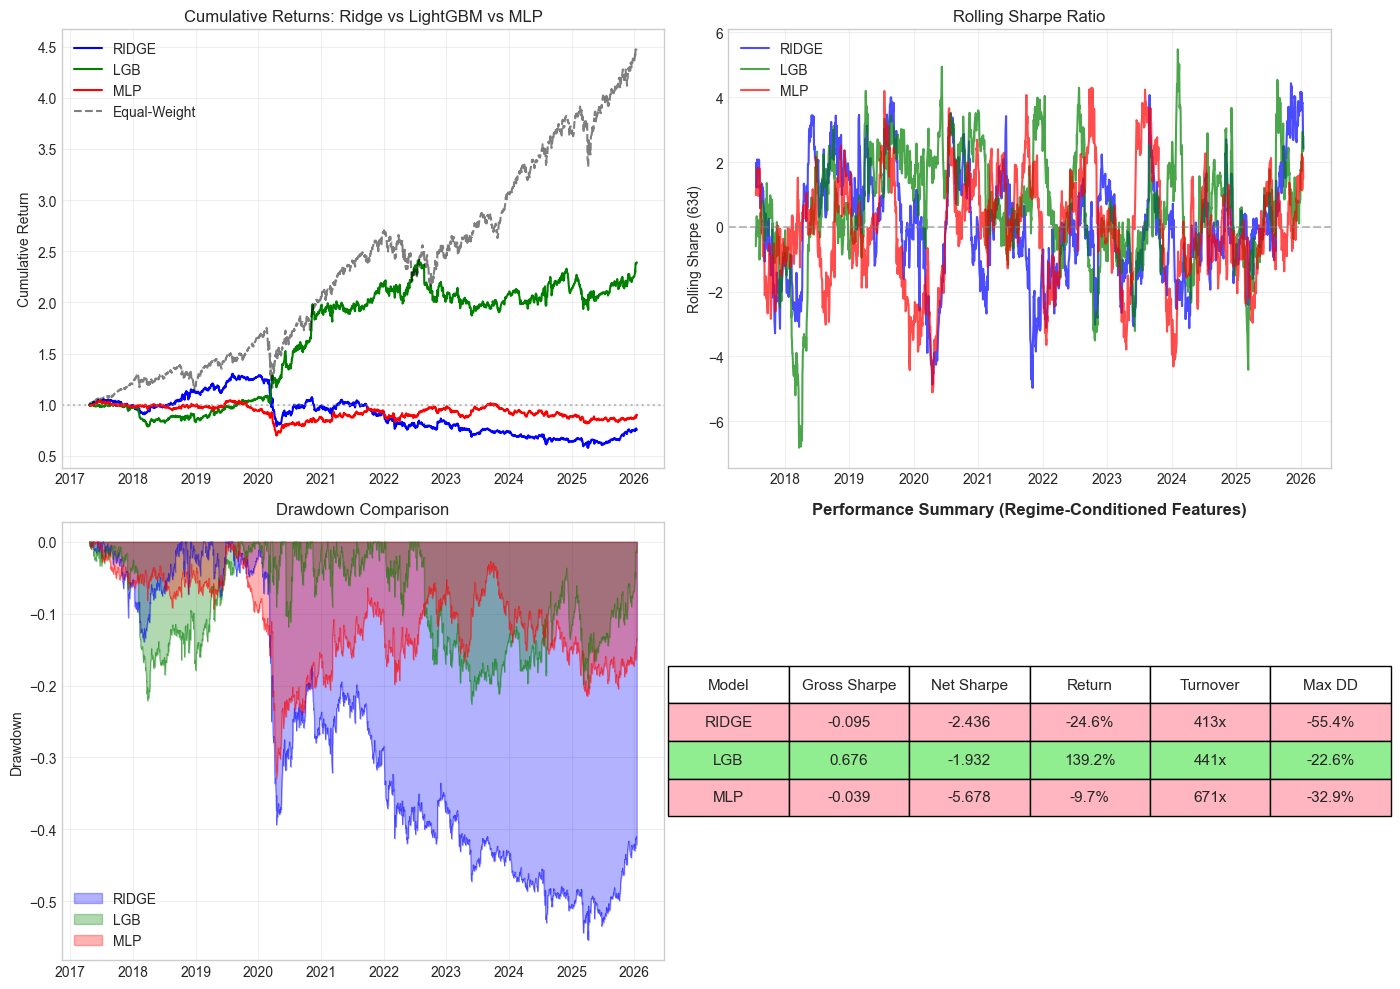


🏆 Best Model: LGB with Gross Sharpe = 0.6763


In [38]:
# =============================================================================
# VISUALIZATION: MULTI-MODEL COMPARISON
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative Returns
ax = axes[0, 0]
colors = {'ridge': 'blue', 'lgb': 'green', 'mlp': 'red'}
for model_name, color in colors.items():
    cum_ret = metrics[model_name]['cum_returns']
    ax.plot(cum_ret.index, cum_ret.values, color=color, label=f"{model_name.upper()}", linewidth=1.5)

# Add equal-weight benchmark
benchmark_ret = multi_results['returns'].mean(axis=1)
benchmark_cum = (1 + benchmark_ret).cumprod()
ax.plot(benchmark_cum.index, benchmark_cum.values, 'k--', label='Equal-Weight', alpha=0.5)

ax.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Returns: Ridge vs LightGBM vs MLP')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Rolling Sharpe (63-day)
ax = axes[0, 1]
for model_name, color in colors.items():
    ret = metrics[model_name]['returns']
    rolling_sharpe = ret.rolling(63).mean() / ret.rolling(63).std() * np.sqrt(252)
    ax.plot(rolling_sharpe.index, rolling_sharpe.values, color=color, label=model_name.upper(), alpha=0.7)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Rolling Sharpe (63d)')
ax.set_title('Rolling Sharpe Ratio')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 3. Drawdowns
ax = axes[1, 0]
for model_name, color in colors.items():
    cum_ret = metrics[model_name]['cum_returns']
    drawdown = cum_ret / cum_ret.cummax() - 1
    ax.fill_between(drawdown.index, 0, drawdown.values, color=color, alpha=0.3, label=model_name.upper())
    ax.plot(drawdown.index, drawdown.values, color=color, alpha=0.5, linewidth=0.5)

ax.set_ylabel('Drawdown')
ax.set_title('Drawdown Comparison')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

# 4. Performance Summary Table
ax = axes[1, 1]
ax.axis('off')

summary_data = []
for model_name in ['ridge', 'lgb', 'mlp']:
    m = metrics[model_name]
    summary_data.append([
        model_name.upper(),
        f"{m['gross_sharpe']:.3f}",
        f"{m['net_sharpe']:.3f}",
        f"{m['total_return']*100:.1f}%",
        f"{m['turnover']:.0f}x",
        f"{m['max_drawdown']*100:.1f}%"
    ])

table = ax.table(
    cellText=summary_data,
    colLabels=['Model', 'Gross Sharpe', 'Net Sharpe', 'Return', 'Turnover', 'Max DD'],
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Color code by Gross Sharpe
for i, model_name in enumerate(['ridge', 'lgb', 'mlp']):
    sharpe = metrics[model_name]['gross_sharpe']
    if sharpe > 0.05:
        color = '#90EE90'  # Light green
    elif sharpe > 0:
        color = '#FFFACD'  # Light yellow
    else:
        color = '#FFB6C1'  # Light red
    for j in range(6):
        table[(i+1, j)].set_facecolor(color)

ax.set_title('Performance Summary (Regime-Conditioned Features)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/multi_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print winner
best_model = max(metrics.keys(), key=lambda x: metrics[x]['gross_sharpe'])
print(f"\n🏆 Best Model: {best_model.upper()} with Gross Sharpe = {metrics[best_model]['gross_sharpe']:.4f}")